<a href="https://colab.research.google.com/github/seven320/-Target_on_with_Arduino/blob/master/nedo_fine_tune_039.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# コンペ情報

-  コンペ名: []()
-  コンペホスト:  [kaggle, signate, probspace]
-  データタイプ:  [テーブル, 画像, その他]
-  予測するデータ:
-  評価指標:

In [ ]:
COMP_BASE = "signate" #["kaggle", "signate", "probspace"]
COMP_NAME = "nedo_finetuning_com" # コンペ名

# 環境準備

In [ ]:
import os, sys, json
COLAB = "google.colab" in sys.modules

if COLAB:
    from google.colab import drive
    from google.colab import output
    drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import copy
import math
from tqdm import tqdm
import hashlib

### 環境確認

In [ ]:
!nvidia-smi

Mon Oct 16 07:38:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!python3 -V

Python 3.10.12


In [ ]:
%cd /content/drive/MyDrive/signate/nedo_finetuning_com/input/run_test

/content/drive/MyDrive/signate/nedo_finetuning_com/input/run_test


In [ ]:
# # google driveにCIFAR10がない時
DATASET="CIFAR100"
INDEX = 39

# !git clone https://github.com/chatflip/ImageRecognitionDataset.git
# %cd ImageRecognitionDataset
# !python src/download.py --dataset {DATASET}
# !mv data/CIFAR10/test data/{DATASET}/val
# %cd ..

In [ ]:
!mkdir -p submits/submit_{INDEX}

In [ ]:
!cp -r submit/* submits/submit_{INDEX}/

In [ ]:
import random
import numpy as np
import torch
import copy, gc, json, math, os, pickle, random, re, time, warnings, logging
from contextlib import contextmanager

#############
## Utility ##
#############
@contextmanager
def timer(name: str):
    t0 = time.time()
    print(f"[{name}] start")
    yield
    print(f"[{name}] done - elapsed {time.time() - t0:.2f}s")

def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results

    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [ ]:
# データを辞書として定義
parallel_params = {
    "path2dir": ".", #
    "rate": 0.2, #0.2
    "category": 100, #10
    "thread": 2, #2
    "seed": 1 #1
}

makedb_params = {
    "rate": 0.2, # 0.2
    "category": 100, #10
    "image_size_x": 256, # 256
    "image_size_y": 256, #256
    "pad_size_x": 6, # 6
    "pad_size_y": 6, # 6
    "iteration": 10000, # 10000
    "draw_type": "patch_color",
    "weight_csv": "./fractal_renderer/weights/weights_0.4.csv",
    "instance": 1
}

ifs_params = {
    "rate": 0.2, # 0.2
    "category": 100, # 10
    "numof_point": 100000, # 100000
    "save_dir":"." # "."
}

with open(f"submits/submit_{INDEX}/params/parallel_params.json", "w") as f:
    json.dump(parallel_params, f)

with open(f"submits/submit_{INDEX}/params/makedb_params.json", "w") as f:
    json.dump(makedb_params, f)

with open(f"submits/submit_{INDEX}/params/ifs_params.json", "w") as f:
    json.dump(ifs_params, f)

!cp submits/submit_{INDEX}/params/*.json params

In [ ]:
!cat params/parallel_params.json

{"path2dir": ".", "rate": 0.2, "category": 100, "thread": 2, "seed": 1}

In [ ]:
!cat params/makedb_params.json

{"rate": 0.2, "category": 100, "image_size_x": 256, "image_size_y": 256, "pad_size_x": 6, "pad_size_y": 6, "iteration": 10000, "draw_type": "patch_color", "weight_csv": "./fractal_renderer/weights/weights_0.4.csv", "instance": 1}

In [ ]:
!cat params/ifs_params.json

{"rate": 0.2, "category": 100, "numof_point": 100000, "save_dir": "."}

In [ ]:
!ls /

bin			    datalab  lib     media		       proc	   sbin  tools
boot			    dev      lib32   mnt		       python-apt  srv	 usr
content			    etc      lib64   NGC-DL-CONTAINER-LICENSE  root	   sys	 var
cuda-keyring_1.0-1_all.deb  home     libx32  opt		       run	   tmp


In [ ]:
# ハッシュを計算する関数
def file_hash(file_path):
    sha256 = hashlib.sha256()
    with open(file_path, "rb") as file:
        # ファイルの内容を読み込んでハッシュを更新
        while True:
            data = file.read(65536)  # 64 KB ブロックでファイルを読み込む
            if not data:
                break
            sha256.update(data)
    return sha256.hexdigest()  # ハッシュの16進数表現を返す

In [ ]:
!ls src/fractal_renderer/

ifs_function.py  make_fractaldb.py  __pycache__  weights


In [ ]:
hash_json = {
    "params_hash1": file_hash("params/parallel_params.json"),
    "params_hash2": file_hash("params/makedb_params.json"),
    "params_hash3": file_hash("params/ifs_params.json"),
    "src_hash": file_hash("src/fractal_renderer/ifs_function.py"),
    "src_hash2": file_hash("src/fractal_renderer/make_fractaldb.py")
}
with open(f"./hash/hash.json", "r") as f:
    previous_hash_json = json.load(f)

In [ ]:
print(previous_hash_json)
print(hash_json)

{'params_hash1': '955116fbd95b6ae28b67f190be7ea63195e82dc3f844a26c638625d2ea38cf1a', 'params_hash2': 'e8ebe35157ec3a7c5a168fb1e72af2fd330e8f5ee8a6918d211800fbd0bac414', 'params_hash3': '8a9d935334dafd209699b9471e6e35cace5bd857204ac1232ab289af29a91b4d', 'src_hash': '55629f3a0248e0c2eeb6e7f902ffe0ff7a3942b2934a9a727b7cc5ac66d8bfca', 'src_hash2': '698b099097a8a0aa5e88de62f804d6fade33cd73cf2f3737d9c8cfd46889dfd1'}
{'params_hash1': '955116fbd95b6ae28b67f190be7ea63195e82dc3f844a26c638625d2ea38cf1a', 'params_hash2': 'e8ebe35157ec3a7c5a168fb1e72af2fd330e8f5ee8a6918d211800fbd0bac414', 'params_hash3': '8a9d935334dafd209699b9471e6e35cace5bd857204ac1232ab289af29a91b4d', 'src_hash': '55629f3a0248e0c2eeb6e7f902ffe0ff7a3942b2934a9a727b7cc5ac66d8bfca', 'src_hash2': '698b099097a8a0aa5e88de62f804d6fade33cd73cf2f3737d9c8cfd46889dfd1'}


In [ ]:
previous_hash_json == hash_json

True

In [ ]:
!mkdir /output
if previous_hash_json == hash_json:
    print("前回と同じ構成のためコピー")
    with timer("make images for pretrain"):
        !rm -r /output
        !cp -r ./output /
else:
    print("前回と異なる構成のため実行")
    with timer("make images for pretrain"):
        !rm -r ./output
        !python run.py --exec-dir ./src --output-data-dir ./output
        !rm -r /output
        !cp -r ./output /

    with open(f"./hash/hash.json", "w") as f:
        json.dump(hash_json, f)

前回と同じ構成のためコピー
[make images for pretrain] start
[make images for pretrain] done - elapsed 129.42s


In [ ]:
assert len(os.listdir("./output")) == len(os.listdir("/output"))
CLASS_NUM = len(os.listdir(f"/output"))
print(CLASS_NUM)

100


# 可視化

### 一つのクラスを可視化

class: 0: 100


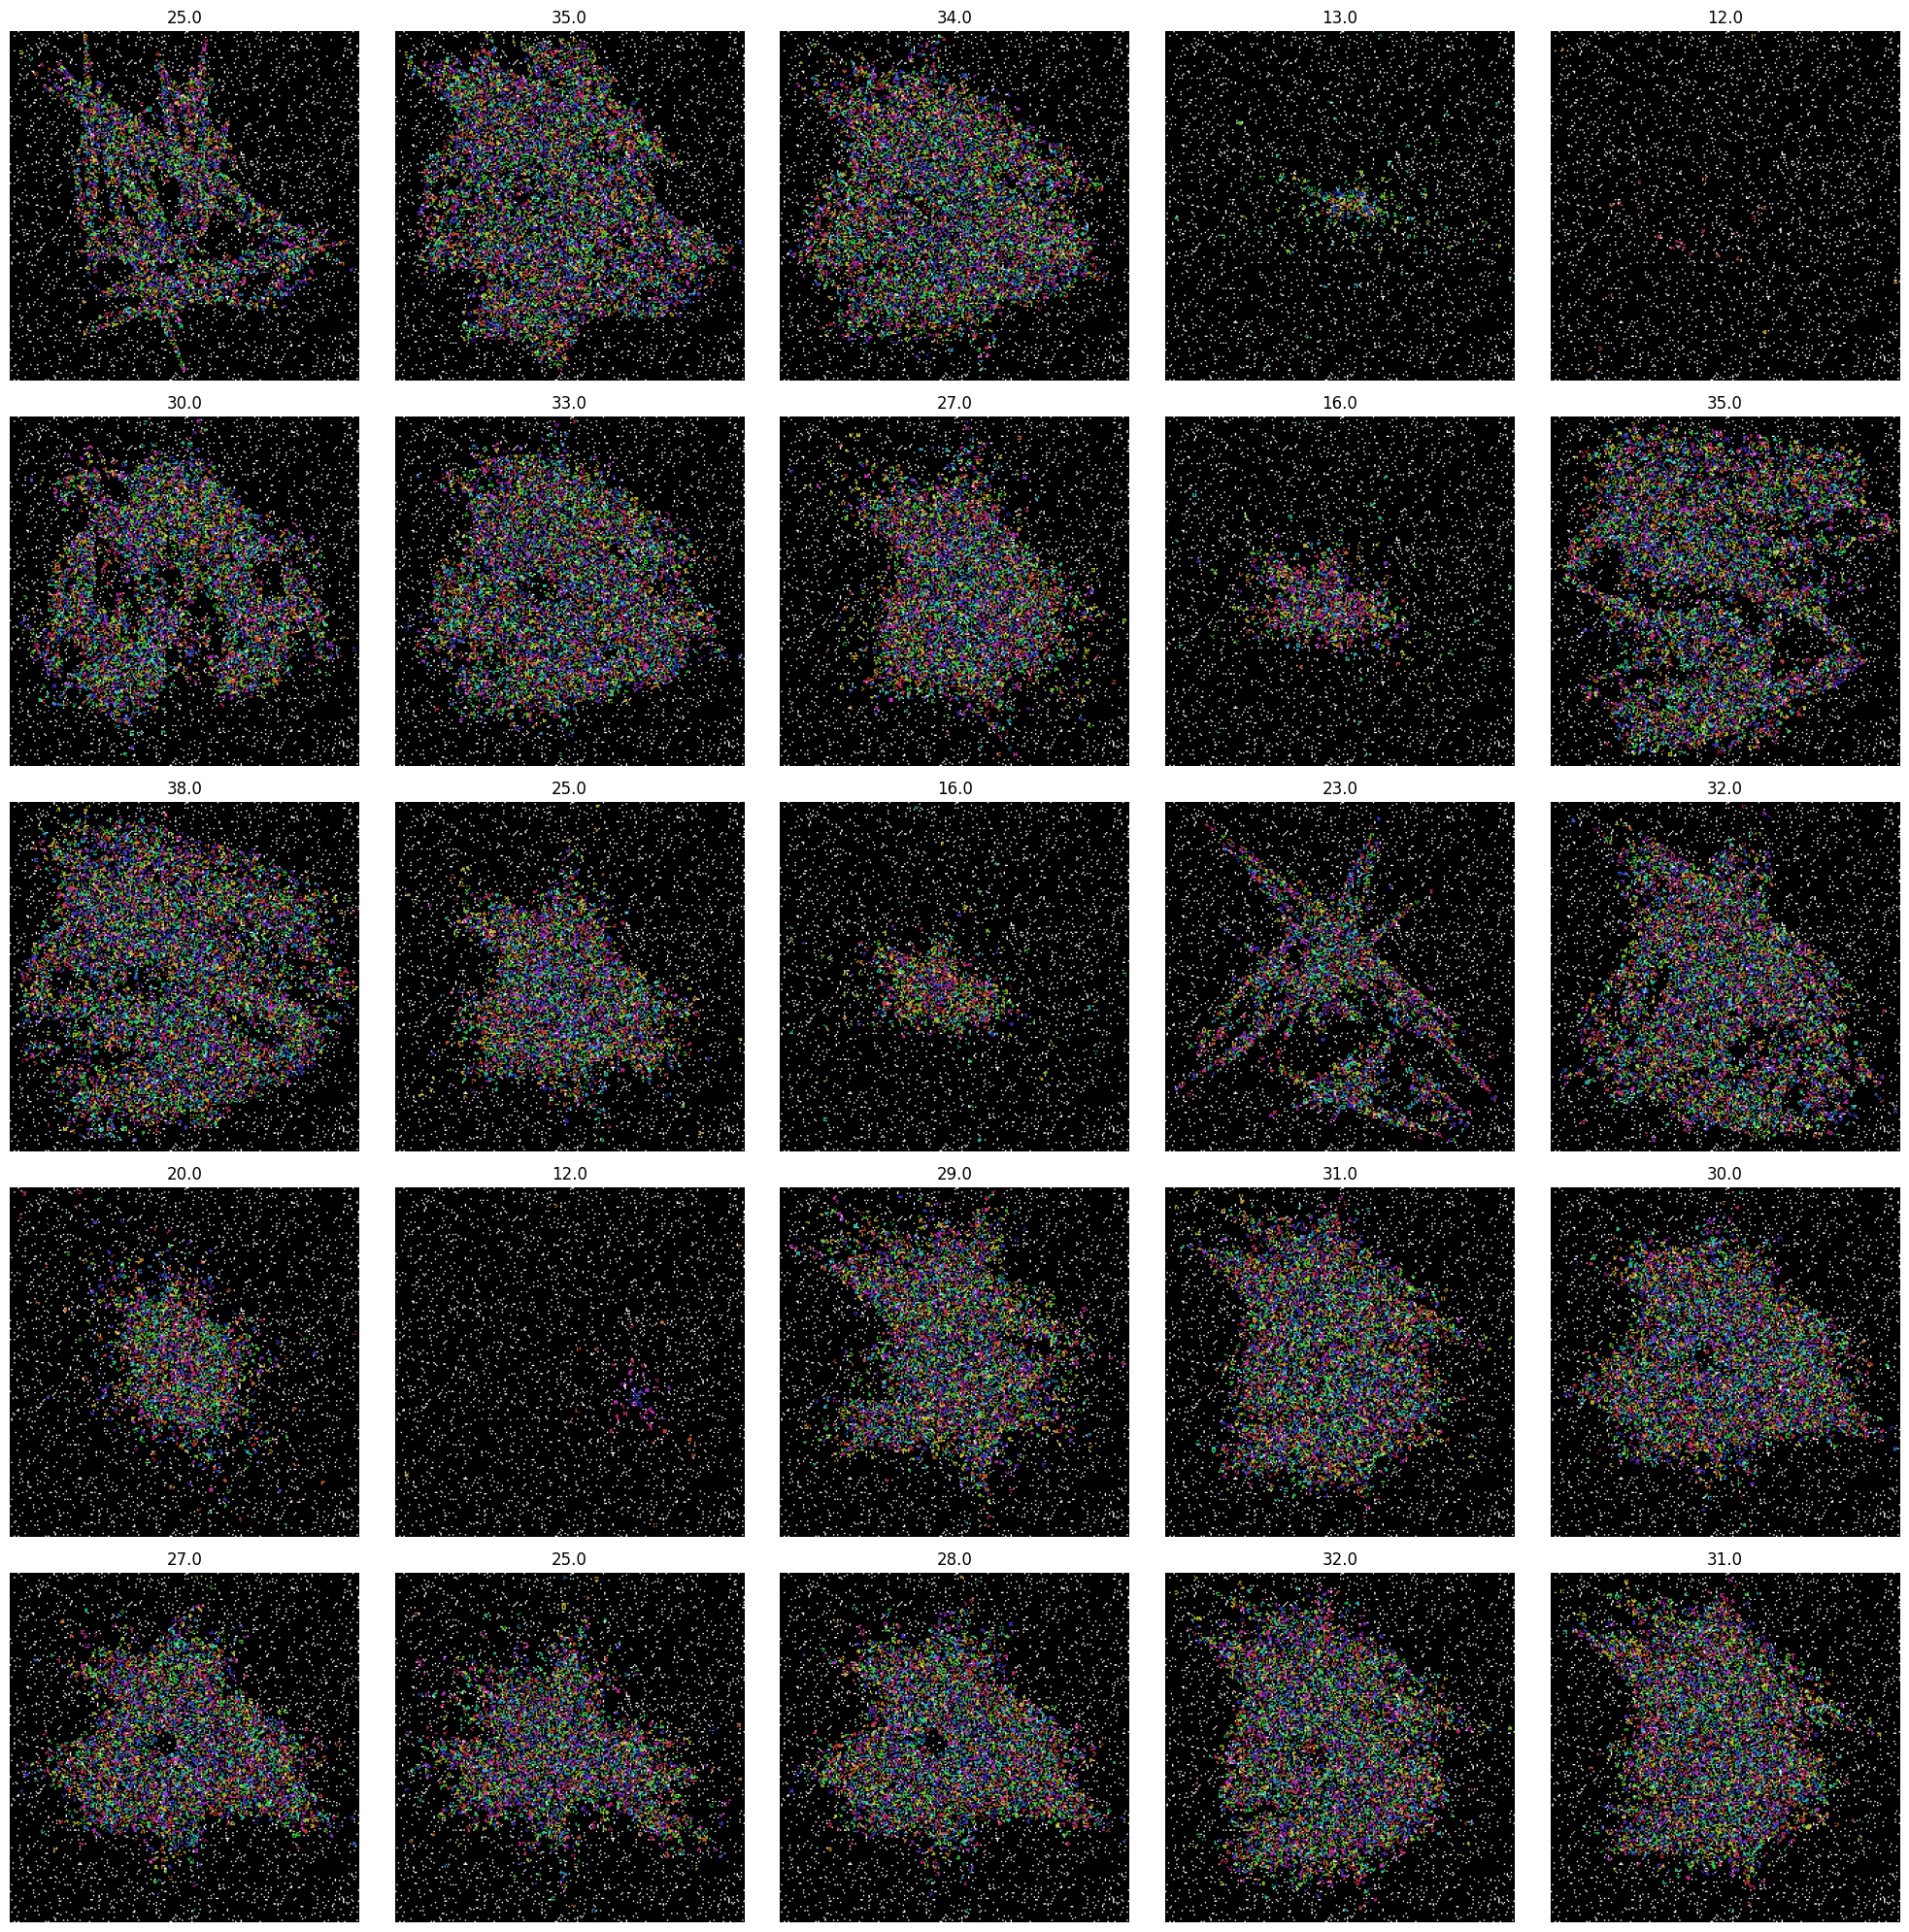

In [ ]:
# 画像ファイルのパス
c_i = 0

images = []
print(f'class: {c_i}: {len(os.listdir(f"/output/{c_i:05}/"))}')
for j in range(25):
    image_path = f"/output/{c_i:05}/{c_i:05}_{j:02}_count_0_noise0.png"
    # 画像を読み込む
    image = cv2.imread(image_path)
    images.append(image)

# 画像を10x1のグリッドとして表示
fig, axes = plt.subplots(5, 5, figsize=(20, 20))  # 5x50のサイズのグリッドを表示するために調整
for i in range(5):
    for j in range(5):
        index = i * 5 + j
        if index < len(images):
            axes[i, j].imshow(images[index])
            axes[i, j].axis('off')  # 軸を非表示にする

        else:
            axes[i, j].axis('off')  # グリッドの外側の軸は非表示にする
        axes[i, j].set_title((np.sum(images[index]) / (256 ** 2 * 3) // 1))

plt.tight_layout()  # レイアウトを調整して適切に表示されるようにする
plt.show()

In [ ]:
# img = cv2.imread('opencv_logo.png')

def filter_blur(image: np.array) -> np.array:
    blur_image = cv2.blur(image, (3,3))
    return blur_image

def add_noise(image: np.array, mean=0, sigma=0.3) -> np.array:
    # 乱数生成をベクトル化してnoiseを生成(256, 256)
    noise = np.round(np.random.normal(mean, sigma, size=image.shape[:2])).astype(np.uint8)

    # 新しい軸を追加して、(256, 256, 1)の形状に変形
    array_3d = noise[:, :, np.newaxis]
    # 各層にコピーして(256, 256, 3)の配列を作成
    noise = np.repeat(array_3d, 3, axis=-1)
    # イメージにnoiseを加算
    noisy_image = image + noise
    # クリッピングを使用して0から255の範囲内に収める
    noisy_image = np.clip(noisy_image, 0, 255)

    return noisy_image

def rotate(image: np.array) -> np.array:
    """
    画像の中心で回転と拡大縮小を実施する
    """
    h, w, c = image.shape
    center_x, center_y= h //2, w//2
    angle_degrees = random.randint(0, 360)

    # x座標とy座標のスケールファクターを指定
    scale = random.uniform(0.5, 1.5)
    rotation_matrix = cv2.getRotationMatrix2D((center_x, center_y), angle_degrees, scale)
    rotate_img = cv2.warpAffine(image, rotation_matrix, (w, h), borderMode=cv2.BORDER_WRAP)
    return rotate_img

def affine(image: np.array) -> np.array:
    h, w, c = image.shape
    # 角度をラジアンに変換
    angle_degrees = 0  # 例として45度とします
    angle_radians = math.radians(angle_degrees)

    # x座標とy座標のスケールファクターを指定
    scale_x = random.uniform(1, 2)  # x座標のスケールファクター
    scale_y = random.uniform(1, 2)  # y座標のスケールファクター

    # アフィン変換行列の作成
    mat = np.array([[scale_x * math.cos(angle_radians), -scale_y * math.sin(angle_radians), 0],
                    [scale_x * math.sin(angle_radians), scale_y * math.cos(angle_radians), 0]],
                dtype=np.float32)

    affine_img = cv2.warpAffine(image, mat, (w, h), borderMode=cv2.BORDER_WRAP)
    return affine_img

def mix(image: np.array, image2: np.array, ratio = 0.6) -> np.array:
    # ratio割合に応じて合成する
    mix_image = np.clip(image * ratio + image2 * (1 - ratio), 0, 255).astype(np.uint8)

    return mix_image

def flip(image: np.array, flip_type: int) -> np.array:
    if flip_type == 0:
        flip_image = image
    elif flip_type == 1:
        flip_image = np.fliplr(image)
    elif flip_type == 2:
        flip_image = np.flipud(image)
    elif flip_type == 3:
        flip_image = np.fliplr(np.flipud(image))
    return flip_image

class: 0: 100


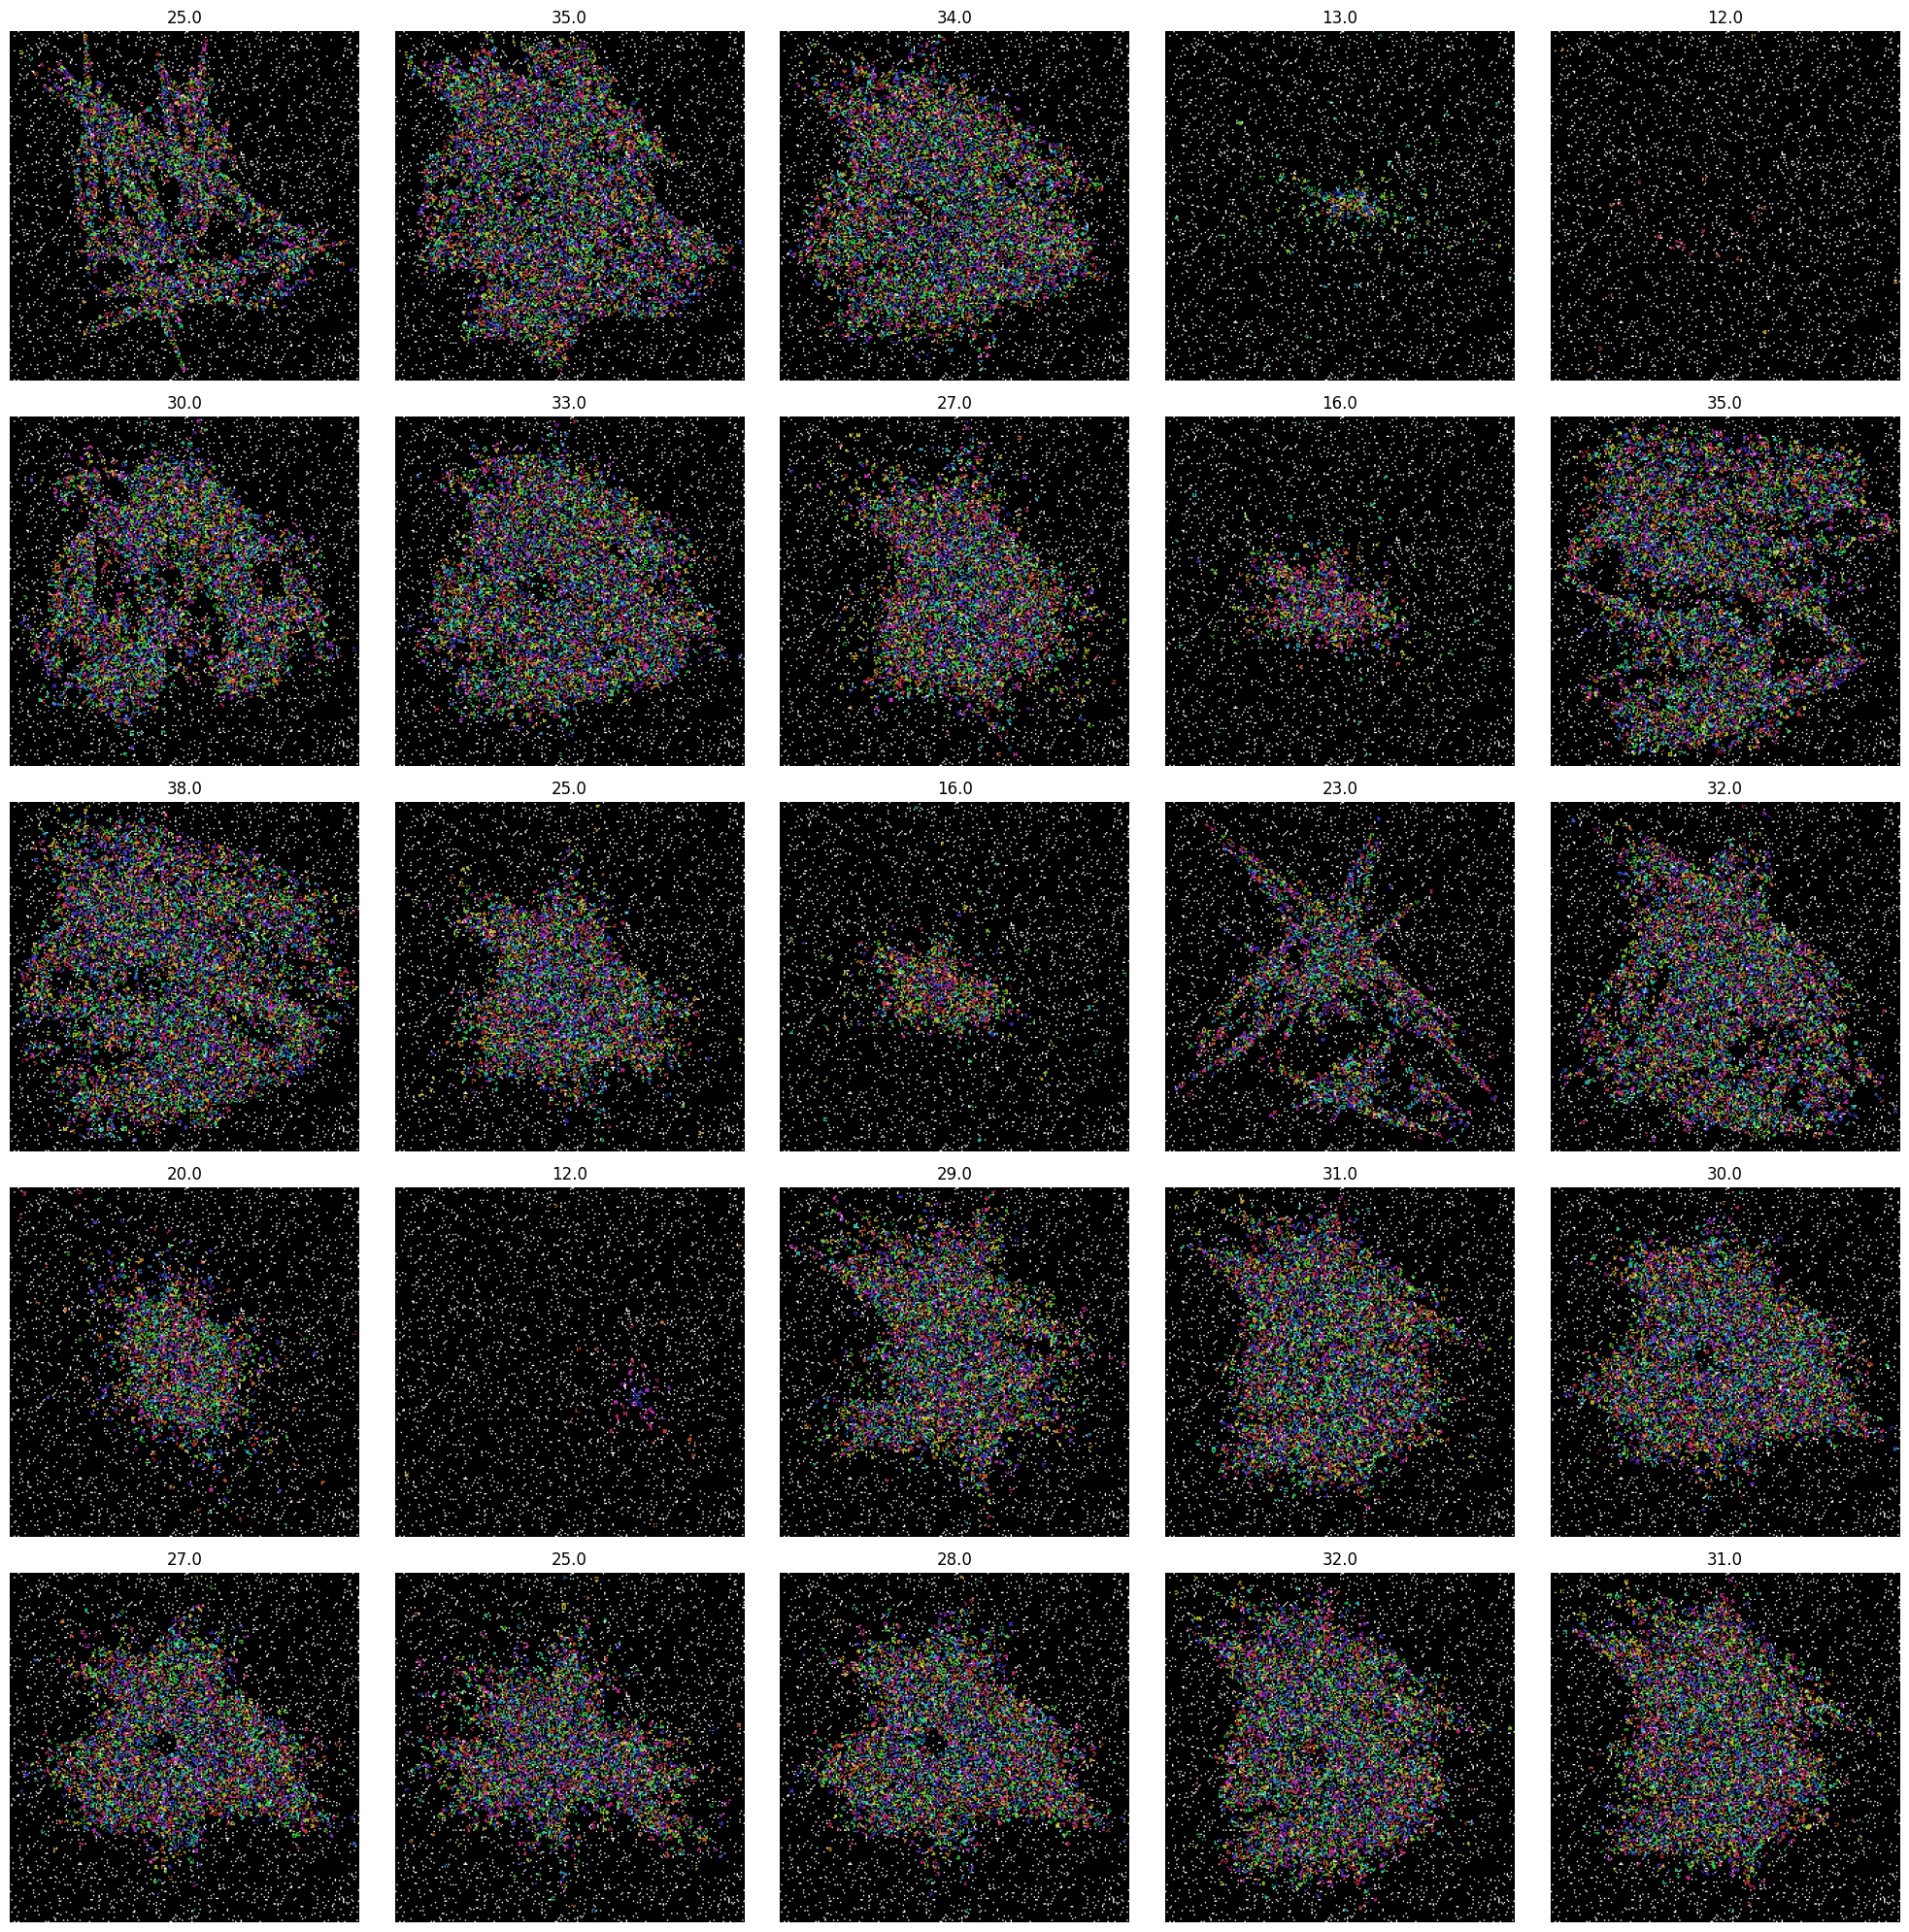

In [ ]:
# 画像ファイルのパス
c_i = 0

images = []
print(f'class: {c_i}: {len(os.listdir(f"/output/{c_i:05}/"))}')
for j in range(25):
    image_path = f"/output/{c_i:05}/{c_i:05}_{j:02}_count_0_noise0.png"
    # 画像を読み込む
    image = cv2.imread(image_path)
    images.append(image)

# 画像を10x1のグリッドとして表示
fig, axes = plt.subplots(5, 5, figsize=(20, 20))  # 5x50のサイズのグリッドを表示するために調整
for i in range(5):
    for j in range(5):
        index = i * 5 + j
        if index < len(images):
            axes[i, j].imshow(images[index])
            axes[i, j].axis('off')  # 軸を非表示にする

        else:
            axes[i, j].axis('off')  # グリッドの外側の軸は非表示にする
        axes[i, j].set_title((np.sum(images[index]) / (256 ** 2 * 3) // 1))

plt.tight_layout()  # レイアウトを調整して適切に表示されるようにする
plt.show()

In [ ]:
OUT_DIR = f"/output"
!python pretrain_finetune.py --input-data-path ./input/input_100_test.json --output-data-dir {OUT_DIR} --weight-dir ./weights --pretrain 1 --test-data-dir ./test --result-dir ./results --result-name scores_{INDEX}.json
# !python pretrain_finetune.py --input-data-path ./input/input.json --output-data-dir {OUT_DIR} --weight-dir ./weights --pretrain 1 --test-data-dir ./test --result-dir ./results --result-name scores_{INDEX}.json

Number of Classes: 100
cuda
00000
100% 100/100 [00:00<00:00, 869.72it/s]
00001
100% 100/100 [00:00<00:00, 901.12it/s]
00002
100% 100/100 [00:00<00:00, 899.84it/s]
00003
100% 100/100 [00:00<00:00, 1022.31it/s]
00004
100% 100/100 [00:00<00:00, 972.45it/s]
00005
100% 100/100 [00:00<00:00, 976.65it/s]
00006
100% 100/100 [00:00<00:00, 895.78it/s]
00007
100% 100/100 [00:00<00:00, 1018.71it/s]
00008
100% 100/100 [00:00<00:00, 984.29it/s]
00009
100% 100/100 [00:00<00:00, 931.09it/s]
00010
100% 100/100 [00:00<00:00, 985.54it/s]
00011
100% 100/100 [00:00<00:00, 940.77it/s]
00012
100% 100/100 [00:00<00:00, 989.76it/s]
00013
100% 100/100 [00:00<00:00, 1079.97it/s]
00014
100% 100/100 [00:00<00:00, 991.69it/s]
00015
100% 100/100 [00:00<00:00, 955.63it/s]
00016
100% 100/100 [00:00<00:00, 1024.01it/s]
00017
100% 100/100 [00:00<00:00, 969.43it/s]
00018
100% 100/100 [00:00<00:00, 1004.08it/s]
00019
100% 100/100 [00:00<00:00, 1065.68it/s]
00020
100% 100/100 [00:00<00:00, 1013.48it/s]
00021
100% 100/100 [

In [ ]:
!ls ./weights/CIFAR100

resnet18_checkpoint.pth.tar  resnet18_epoch10.pth


In [ ]:
from finetuning.model_select import model_select

use pretrained model : ./weights/CIFAR100/resnet18_epoch10.pth


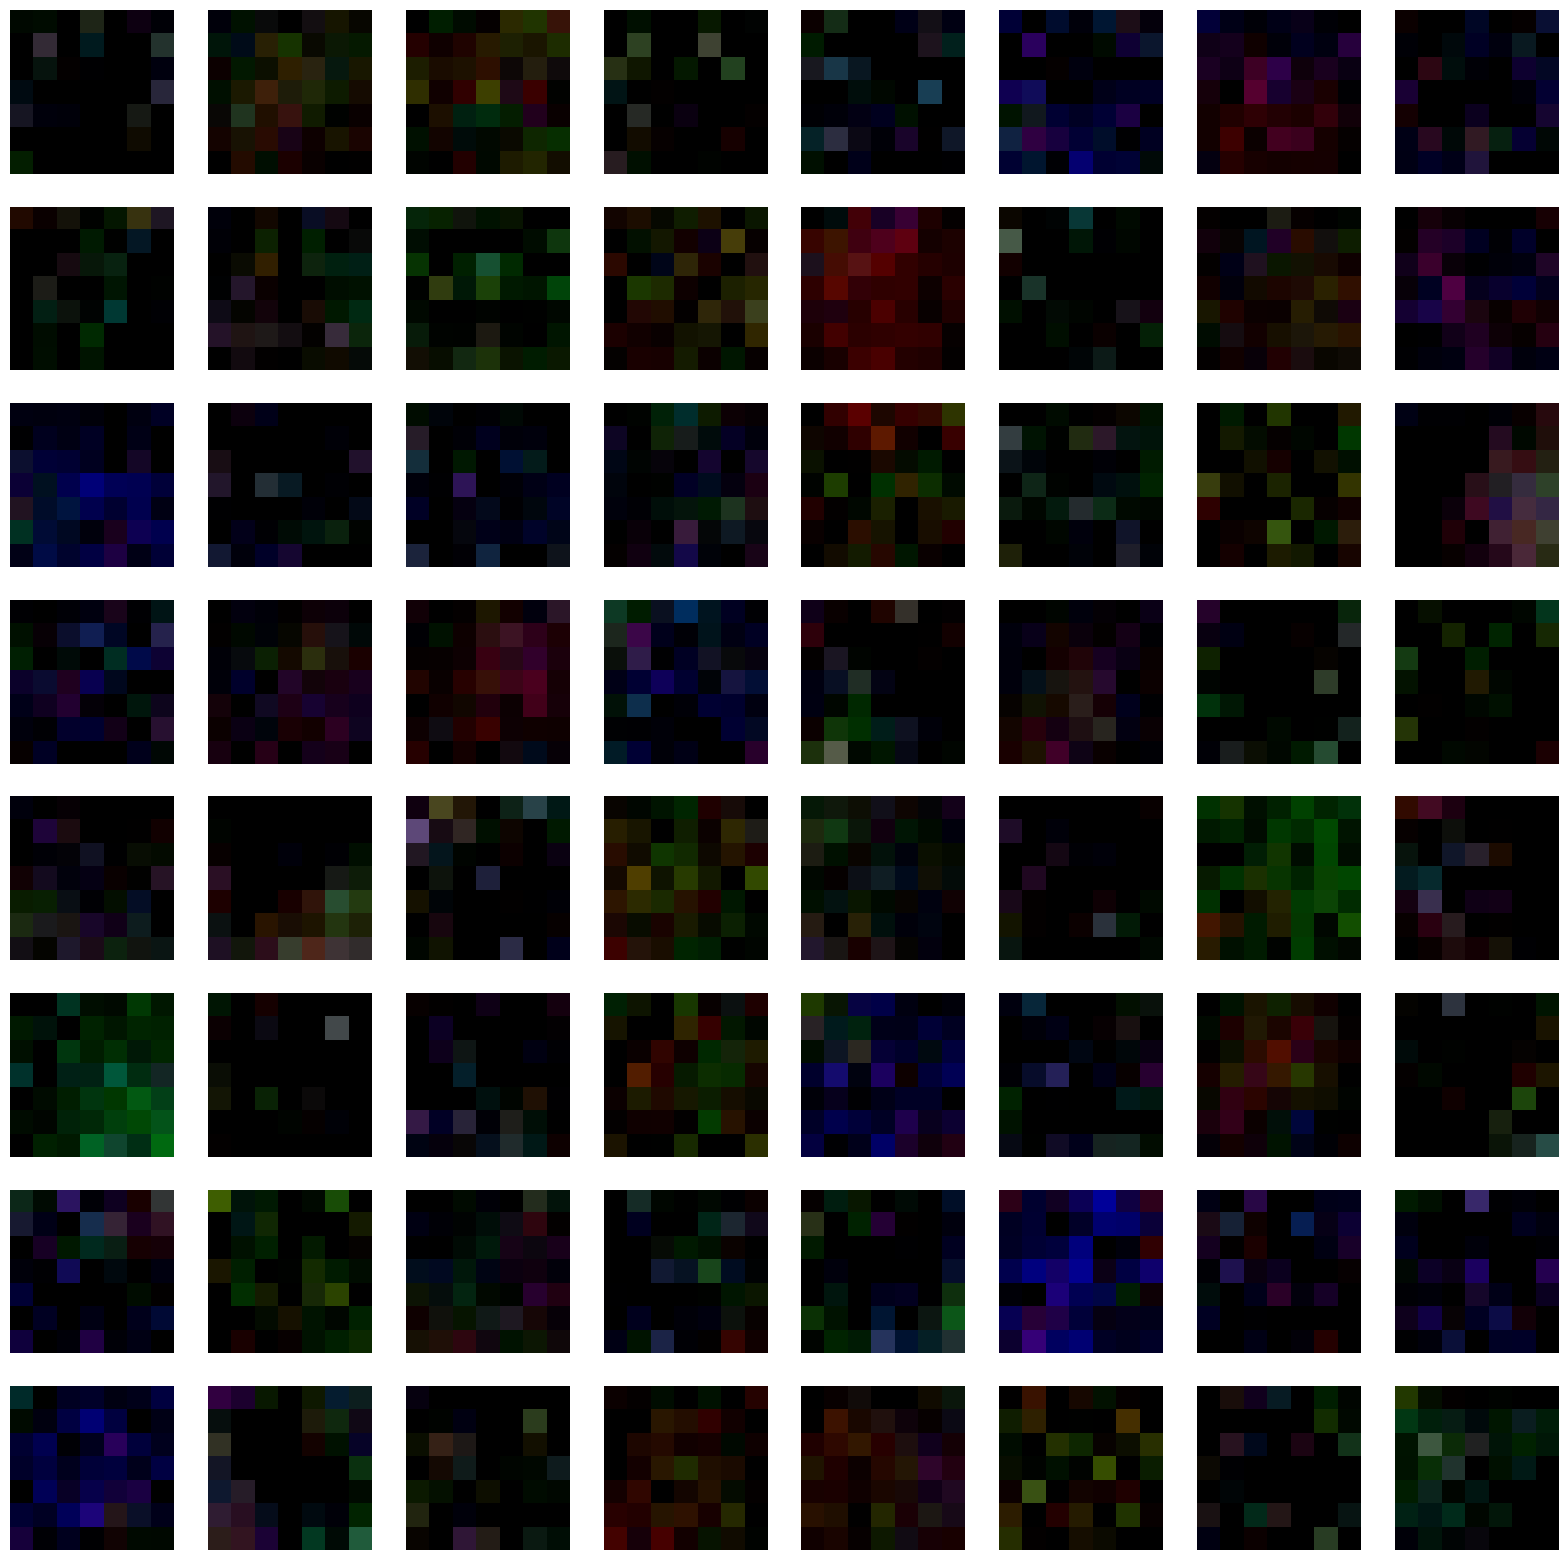

In [ ]:
model_1 = model_select("./weights/CIFAR100", "resnet18", 100, 100, 10)

convs = model_1.conv1.weight

# 画像を10x1のグリッドとして表示
fig, axes = plt.subplots(8,8, figsize=(20, 20))  # 5x50のサイズのグリッドを表示するために調整

for c_i, conv in enumerate(convs):
    i = c_i // 8
    j = c_i % 8

    axes[i, j].imshow(conv.permute(1,2,0).detach().numpy())
    axes[i, j].axis("off")

In [ ]:
model_1 = model_select("./weights/CIFAR100", "resnet18", 100, 100, 10)

convs_1 = model_1.conv1.weight

model_1 = model_select("./weights/CIFAR100", "resnet18", 100, 100, 10)
checkpoint = torch.load("./weights/CIFAR100/resnet18_checkpoint.pth.tar")

model_1.load_state_dict(checkpoint["state_dict"])
convs_2 = model_1.conv1.weight

use pretrained model : ./weights/CIFAR100/resnet18_epoch10.pth
use pretrained model : ./weights/CIFAR100/resnet18_epoch10.pth


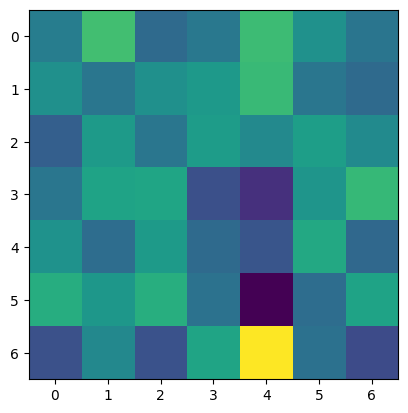

In [ ]:
plt.imshow(conv.sum(axis = 0).detach().numpy())

plt.imshow(np.linalg.inv(conv.sum(axis = 0).detach().numpy()))

In [ ]:
!ls ./weights/CIFAR100/

resnet18_checkpoint.pth.tar  resnet18_epoch10.pth


use pretrained model : ./weights/CIFAR100/resnet18_epoch10.pth


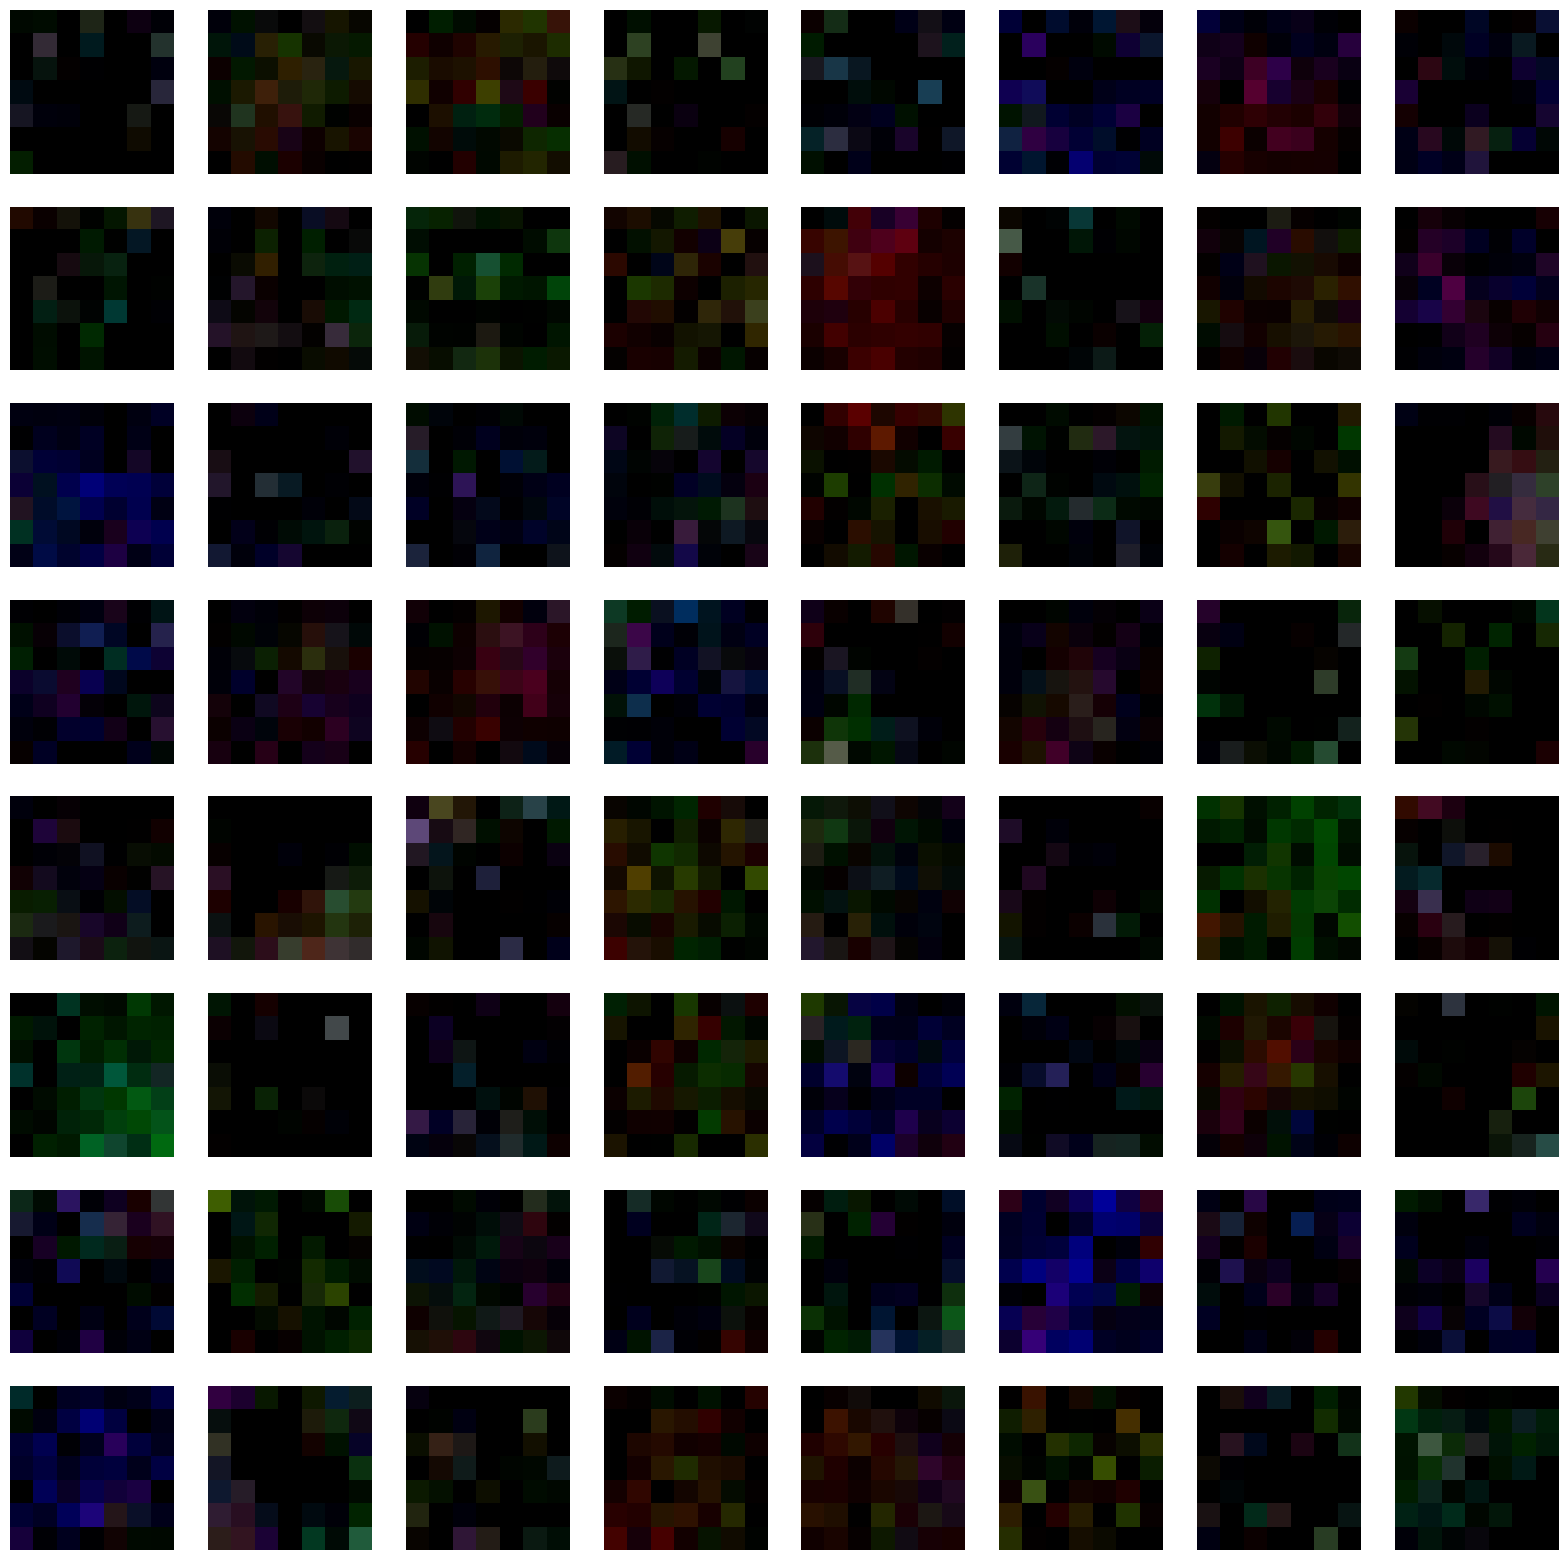

In [ ]:
model_1 = model_select("./weights/CIFAR100", "resnet18", 100, 100, 10)
checkpoint = torch.load("./weights/CIFAR100/resnet18_checkpoint.pth.tar")

model_1.load_state_dict(checkpoint["state_dict"])
convs = model_1.conv1.weight

# 画像を10x1のグリッドとして表示
fig, axes = plt.subplots(8,8, figsize=(20, 20))  # 5x50のサイズのグリッドを表示するために調整

for c_i, conv in enumerate(convs):
    i = c_i // 8
    j = c_i % 8

    axes[i, j].imshow(conv.permute(1,2,0).detach().numpy())
    axes[i, j].axis("off")

In [ ]:
### kaggleにおいてファイル提出が可能な場合
if COMP_BASE == "kaggle":
    !kaggle competitions submit -c {COMP_NAME} -f submission.csv -m {NOTEBOOK_NAME}
elif COMP_BASE == "signate":
    !signate submit --competition-id={} sub_df --note {NOTEBOOK_NAME}

/bin/bash: line 1: signate: command not found
